# Gigs Senior Data Analyst Challenge

Welcome to the Gigs data analyst take-home challenge! This notebook will help you get started with analyzing our connectivity usage data.

## About the Data

You'll be working with three main datasets:
- **Usage Data**: Detailed usage per subscription period (~100K+ records)
- **Plan Events**: Plan configuration and pricing history
- **Projects**: Project metadata

## Setup Instructions

Run the cells below to set up your environment and load the data into DuckDB.

In [2]:
# Import required libraries
import duckdb
import pandas as pd
from datetime import datetime, timedelta

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
# Load JupySQL extension and configure
%load_ext sql

# Configure JupySQL for better output
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

print("✅ JupySQL configured!")

✅ JupySQL configured!


In [4]:
# Connect to DuckDB
conn = duckdb.connect('gigs-analytics.db')
%sql conn --alias duckdb

print("✅ Connected to DuckDB database: gigs-analytics.db")

✅ Connected to DuckDB database: gigs-analytics.db


In [6]:
%%sql
-- Verify data loading
SELECT
  'usage_data' AS table_name,
  COUNT(*) AS row_count,
  COUNT(DISTINCT subscription_id) AS unique_subscriptions
FROM
  usage_data
UNION ALL
SELECT
  'plan_events' AS table_name,
  COUNT(*) AS row_count,
  COUNT(DISTINCT plan_id) AS unique_plans
FROM
  plan_events
UNION ALL
SELECT
  'projects' AS table_name,
  COUNT(*) AS row_count,
  COUNT(DISTINCT project_id__hashed) AS unique_projects
FROM
  projects;

,table_name,row_count,unique_subscriptions
0,usage_data,53565,8457
1,plan_events,209,36
2,projects,3,3


In [5]:
%%sql
-- Load data into DuckDB tables
CREATE
OR REPLACE TABLE usage_data AS
SELECT
  *
FROM
  'data/usage_by_subscription_period.csv';

CREATE
OR REPLACE TABLE plan_events AS
SELECT
  *
FROM
  'data/plan_change_events.csv';

CREATE
OR REPLACE TABLE projects AS
SELECT
  *
FROM
  'data/projects.csv';

,Count
0,3


## Your Analysis Starts Here!

Now you have everything set up. Use the cells below to start your analysis.

### Tips:
- Use `%%sql` for multi-line SQL queries
- Use `%sql variable_name <<` to store results in a Python variable
- Combine SQL with Python/Pandas for advanced analysis
- Feel free to use any visualisation library you feel comfortable with

Prep: Data Exploration

In [357]:
%%sql 
SELECT
  validity_value,
  validity_unit,
  COUNT(DISTINCT plan_id) AS plans
FROM
  plan_events
GROUP BY ALL
  -- getting an idea for the types of plans sold

,validity_value,validity_unit,plans
0,30,month,1
1,30,day,19
2,1,month,16


Question 1: How much data does a subscription typically consume? 

Will get data per subscription & check both mean and median to see how usage is distributed.

In [358]:
%%sql 
-- Checking if there's any null values for the columns we want to use 
SELECT
  COUNT(*) AS total_rows,
  COUNT(cumulative_data_usage_megabyte) AS non_null_count,
  COUNT(*) - COUNT(cumulative_data_usage_megabyte) AS null_count,
  COUNT(subscription_id) AS non_null_count,
  COUNT(*) - COUNT(subscription_id) AS null_count
FROM
  usage_data

,total_rows,non_null_count,null_count,non_null_count_1,null_count_1
0,53565,53565,0,53565,0


In [402]:
%%sql usage_data_sub_df <<
SELECT
  subscription_id,
  SUM(cumulative_data_usage_megabyte / 1000) AS cumulative_data_usage_gb
FROM
  usage_data
GROUP BY
  subscription_id
  /* 
  Summing the data usage by subscription for further analysis 
  & moving to GB for easier interpretation
  */

In [403]:
# Check output 
usage_data_sub_df.head()

,subscription_id,cumulative_data_usage_gb
0,sub_79028c07c5eb4e64ad1f23ac7d57,0.062925
1,sub_b31d73742aa9431346bc19f5912b,0.052355
2,sub_ca64333ea71eccafa2b4486ee638,2.580198
3,sub_f97dc93769dc8ae36e9f6f509f06,2.268380
4,sub_ff215773f5114e5326172271aa14,2.824059


<function matplotlib.pyplot.show(close=None, block=None)>

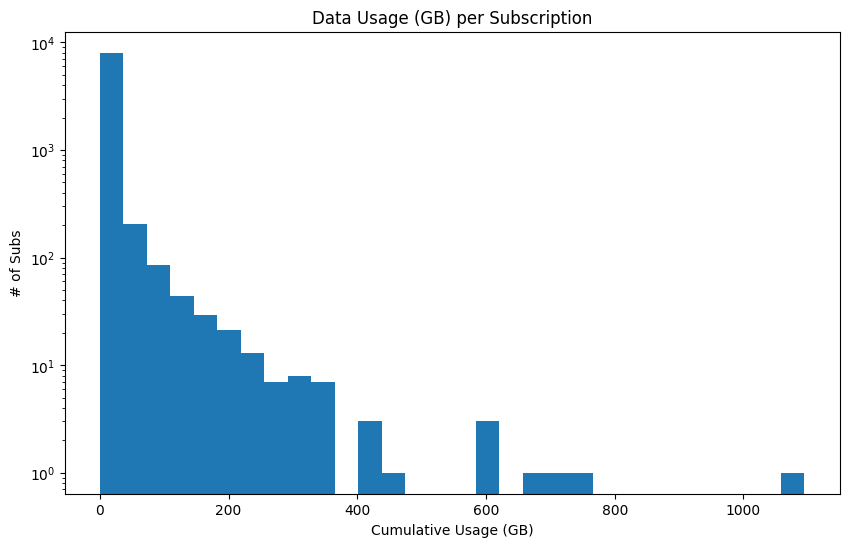

In [404]:
#Code for chart generated with AI 
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(usage_data_sub_df['cumulative_data_usage_gb'], bins=30)

plt.title('Data Usage (GB) per Subscription')
plt.xlabel('Cumulative Usage (GB)')
plt.ylabel('# of Subs')
plt.yscale('log') 

plt.show

In [405]:
%%sql usage_data_sub_metrics_df <<
WITH
  sub_data AS (
    SELECT
      subscription_id,
      SUM(cumulative_data_usage_megabyte / 1000) AS cumulative_data_usage_gb
    FROM
      usage_data
    GROUP BY
      subscription_id
  )
SELECT
  AVG(cumulative_data_usage_gb) AS mean_usage,
  PERCENTILE_CONT(0.5) WITHIN GROUP (
    ORDER BY
      cumulative_data_usage_gb
  ) AS median_usage,
  PERCENTILE_CONT(0.25) WITHIN GROUP (
    ORDER BY
      cumulative_data_usage_gb
  ) AS quartile_25,
  PERCENTILE_CONT(0.75) WITHIN GROUP (
    ORDER BY
      cumulative_data_usage_gb
  ) AS quartile_75,
  MIN(cumulative_data_usage_gb) AS min_usage,
  MAX(cumulative_data_usage_gb) AS max_usage,
  VAR_SAMP(cumulative_data_usage_gb) AS variance_usage,
  STDDEV_SAMP(cumulative_data_usage_gb) AS stddev_usage
FROM
  sub_data

In [406]:
# Check output 
usage_data_sub_metrics_df.head()

,mean_usage,median_usage,quartile_25,quartile_75,min_usage,max_usage,variance_usage,stddev_usage
0,8.952292,1.154734,0.158095,4.684116,0.0,1094.672239,1252.664429,35.393


Findings: 
- The data is heavily skewed, so we are using the median instead of the average. The median is 1.15GB, with 25% using less than 0.16GB and 75% less than 4.7GB
- The mean is much higher than the median (8.95GB vs 1.15GB) indicating that they are a few heavy users which up the mean


Question 2: How does usage look like at different plan allowances?
We will join the usage data on the plan data to check allowance per period. We then will get some descriptive statistics, will plot the data and eventually compare by plan size.

In [370]:
%%sql
WITH
  allowance_sub_data AS (
    SELECT
      subscription_id,
      CONCAT (validity_value, ' ', validity_unit) AS sub_period,
      CASE
        WHEN is_unlimited_data = TRUE THEN 'Unlimited'
        ELSE CAST(data_allowance_mb / 1000 AS TEXT)
      END AS data_allowance_gb,
      cumulative_data_usage_megabyte / 1000 AS cumulative_data_usage_gb
    FROM
      usage_data AS sub
      INNER JOIN plan_events AS plan ON plan.plan_id = sub.plan_id
      AND sub.subscription_period_start <= plan._valid_to
      AND sub.subscription_period_end >= plan._valid_from
  )
SELECT
  data_allowance_gb AS plan_allowance,
  AVG(cumulative_data_usage_gb) AS mean_usage,
  PERCENTILE_CONT(0.5) WITHIN GROUP (
    ORDER BY
      cumulative_data_usage_gb
  ) AS median_usage,
  PERCENTILE_CONT(0.25) WITHIN GROUP (
    ORDER BY
      cumulative_data_usage_gb
  ) AS quartile_25,
  PERCENTILE_CONT(0.75) WITHIN GROUP (
    ORDER BY
      cumulative_data_usage_gb
  ) AS quartile_75,
  MIN(cumulative_data_usage_gb) AS min_usage,
  MAX(cumulative_data_usage_gb) AS max_usage,
  VAR_SAMP(cumulative_data_usage_gb) AS variance_usage,
  STDDEV_SAMP(cumulative_data_usage_gb) AS stddev_usage
FROM
  allowance_sub_data
GROUP BY
  data_allowance_gb
ORDER BY
  CASE
    WHEN data_allowance_gb = 'Unlimited' THEN 999999
    ELSE CAST(data_allowance_gb AS FLOAT)
  END;

,plan_allowance,mean_usage,median_usage,quartile_25,quartile_75,min_usage,max_usage,variance_usage,stddev_usage
0,1.0,0.364559,0.111298,0.005066,0.348356,0.0,110.371431,1.541222,1.241460
1,5.0,1.754447,0.352739,0.023567,2.494738,0.0,250.785321,31.356590,5.599696
2,Unlimited,10.558668,1.922484,0.036954,10.641838,0.0,282.946536,564.590626,23.761116


In [371]:
%%sql usage_data_per_plan_allowance <<
SELECT
  subscription_id,
  CONCAT (validity_value, ' ', validity_unit) AS sub_period,
  CASE
    WHEN is_unlimited_data = TRUE THEN 'Unlimited'
    ELSE CAST(data_allowance_mb / 1000 AS TEXT)
  END AS data_allowance_gb,
  cumulative_data_usage_megabyte / 1000 AS cumulative_data_usage_gb
FROM
  usage_data AS sub
  INNER JOIN plan_events AS plan ON plan.plan_id = sub.plan_id
  AND sub.subscription_period_start <= plan._valid_to
  AND sub.subscription_period_end >= plan._valid_from
  /* 
  Combining usage with plan information data to get usage allowances
  */

In [372]:
usage_data_per_plan_allowance.head()

,subscription_id,sub_period,data_allowance_gb,cumulative_data_usage_gb
0,sub_3f4dad4c8b9a0a47e9978a52a9f7,1 month,5.0,0.000000
1,sub_b97107a1c7ef89cf28a7e83ee850,1 month,1.0,0.000000
2,sub_2353ef9e8bf55916b97ceb30194c,1 month,1.0,0.056661
3,sub_8e114d3a638d12ca1526a3fbedd6,1 month,1.0,0.156871
4,sub_16059484727214a6b903fa16d0fe,1 month,1.0,0.000000


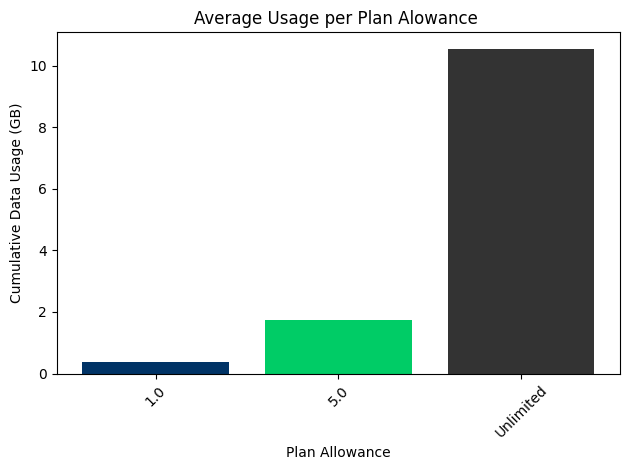

In [376]:
#Code for chart generated with AI 
import matplotlib.pyplot as plt
import numpy as np

order = ["1.0", "5.0", "Unlimited"]
colors = ['#003366', '#00CC66', '#333333']

# Aggregate data
avg_usage = usage_data_per_plan_allowance.groupby("data_allowance_gb")["cumulative_data_usage_gb"].mean()
avg_usage = avg_usage.reindex(order)  # assigning order specified above 

# Plot
fig, ax = plt.subplots()

bars = ax.bar(avg_usage.index, avg_usage.values, color=colors)

ax.set_xlabel("Plan Allowance")
ax.set_ylabel("Cumulative Data Usage (GB)")
ax.set_title("Average Usage per Plan Alowance ")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


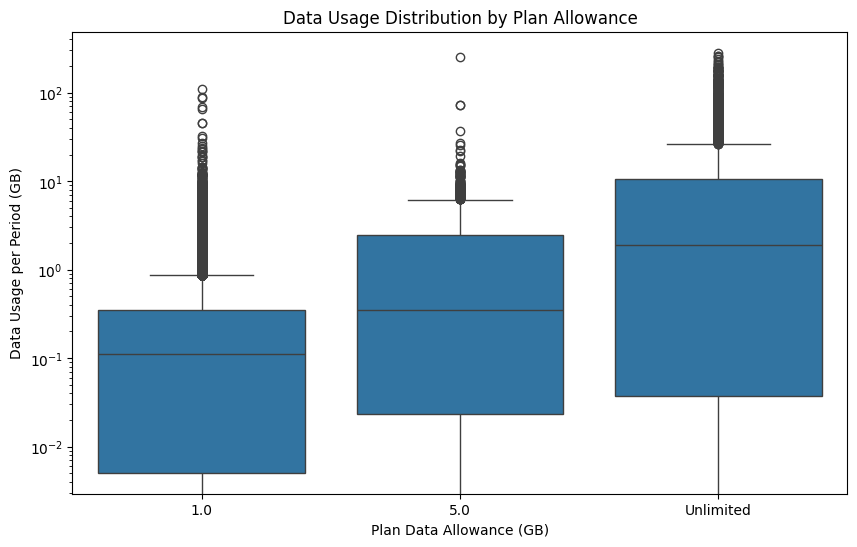

In [396]:
#Code for chart generated with AI 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(
    data=usage_data_per_plan_allowance, 
    x='data_allowance_gb', 
    y='cumulative_data_usage_gb',
    order=["1.0", "5.0", "Unlimited"]
)

plt.xlabel('Plan Data Allowance (GB)')
plt.ylabel('Data Usage per Period (GB)')
plt.title('Data Usage Distribution by Plan Allowance')
plt.yscale('log') 
plt.show()


Findings: 
- Users adjust behavior based on allowance: higher plan sizes see higher average (mean) and typical (median) usage numbers
- The variance increases as the plan size increases, meaning that users in the higher plans differ a lot more from each other than those in smaller plans
- The median is much lower than the mean -> indicates that few heavy users skew the mean 
- One thing the plans have in common that the bottom 25% users very little data

Question 3: subscriptions typically consume consistent amounts of data throughout their lifetime?

To answer this question, we first check how long users typically stay, since users who have only a few periods available might heavily impact the data. First we will check that out, after which we will make a decsion on how to proceed. 

In [387]:
%%sql usage_data_dev_df <<
SELECT
  subscription_id,
  subscription_period_number,
  (cumulative_data_usage_megabyte / 1000) AS cumulative_data_usage_gb
FROM
  usage_data
  /* 
  Getting period level data so we can understand the development
  */

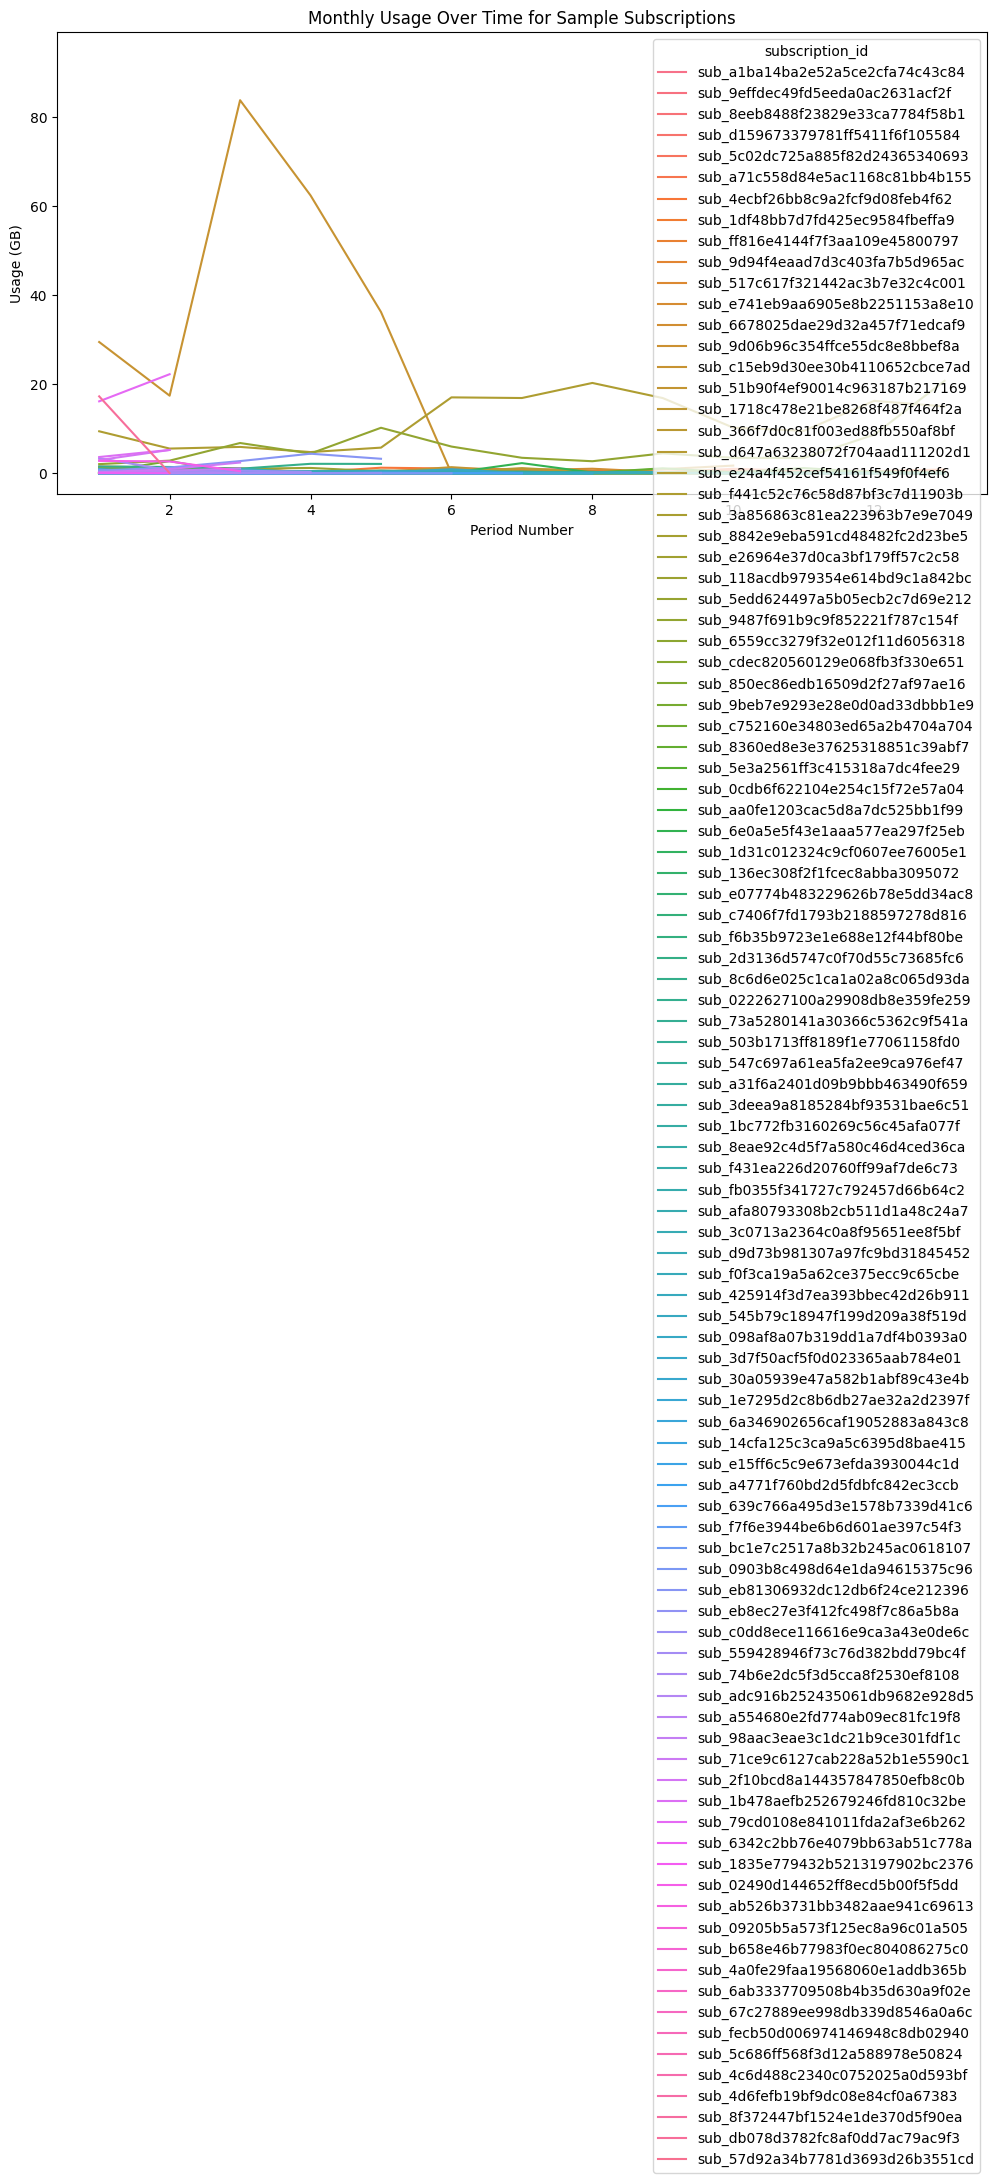

In [388]:
#Code for chart generated with AI 
# Look at a few random subscriptions to see how usage changes
sample_ids = usage_data_dev_df['subscription_id'].drop_duplicates().sample(100)

# Filter data
sample_data = usage_data_dev_df[usage_data_dev_df['subscription_id'].isin(sample_ids)]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=sample_data, x="subscription_period_number", y="cumulative_data_usage_gb", hue="subscription_id")
plt.xlabel("Period Number")
plt.ylabel("Usage (GB)")
plt.title("Monthly Usage Over Time for Sample Subscriptions")
plt.show()

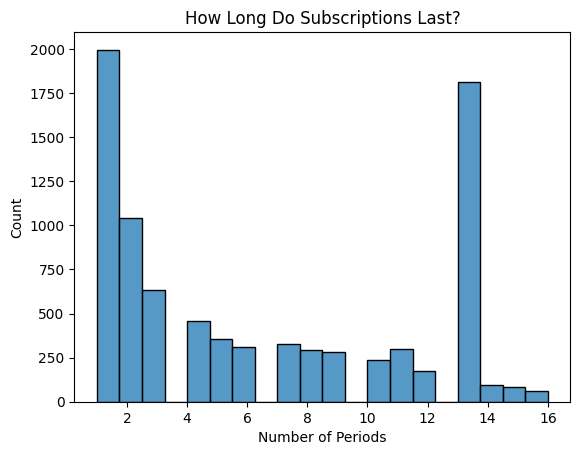

In [389]:
#Code for chart generated with AI 
# Checking how many periods we have available for subscriptions
periods_per_sub = usage_data_dev_df.groupby("subscription_id")["subscription_period_number"].nunique().reset_index(name="num_periods")

sns.histplot(periods_per_sub["num_periods"], bins=20)
plt.xlabel("Number of Periods")
plt.title("How Long Do Subscriptions Last?")
plt.show()


In [390]:
# Check percentage of users under 4
percentage_under_4 = (
    (usage_data_dev_df.groupby("subscription_id")["subscription_period_number"].count() < 4).mean() * 100
)

print(f"{percentage_under_4:.2f}% of subscriptions have fewer than 4 periods.")


43.19% of subscriptions have fewer than 4 periods.


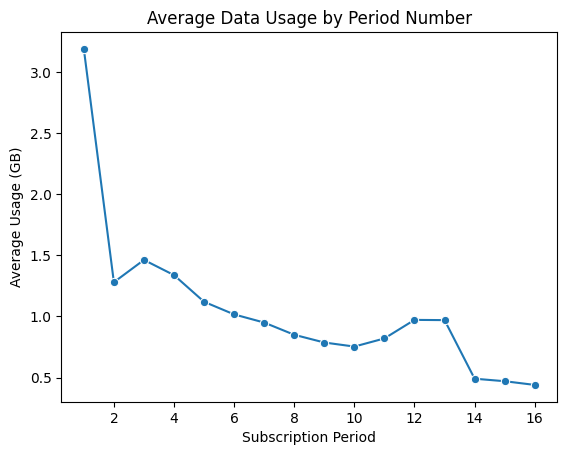

In [391]:
#Code for chart generated with AI 
avg_by_period = usage_data_dev_df.groupby("subscription_period_number")["cumulative_data_usage_gb"].mean().reset_index()

sns.lineplot(data=avg_by_period, x="subscription_period_number", y="cumulative_data_usage_gb", marker="o")
plt.xlabel("Subscription Period")
plt.ylabel("Average Usage (GB)")
plt.title("Average Data Usage by Period Number")
plt.show()


As we have quite a few users in the 1-3 periods bucket, we will look at them separately and keep the others for the usage analysis. 

In [407]:
# Calculate subscription length
subscription_lengths = (
    usage_data_dev_df
    .groupby("subscription_id")["subscription_period_number"]
    .count()
    .reset_index()
    .rename(columns={"subscription_period_number": "num_periods"})
)


In [393]:
# Calculate standard deviation of usage per subscription
std_per_subscription = (
    usage_data_dev_df
    .groupby("subscription_id")["cumulative_data_usage_gb"]
    .std()
    .reset_index()
    .rename(columns={"cumulative_data_usage_gb": "std_usage_gb"})
)

# Merge with period count
variability_df = std_per_subscription.merge(subscription_lengths, on="subscription_id")

# Categorize subscriptions
variability_df["group"] = variability_df["num_periods"].apply(lambda x: "<4 periods" if x < 4 else "≥4 periods")


/var/folders/wm/dq5683lx2ts6hvf9yn_m3w5h0000gp/T/ipykernel_41132/3765080991.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped, labels=["<4 periods", "≥4 periods"], patch_artist=True,


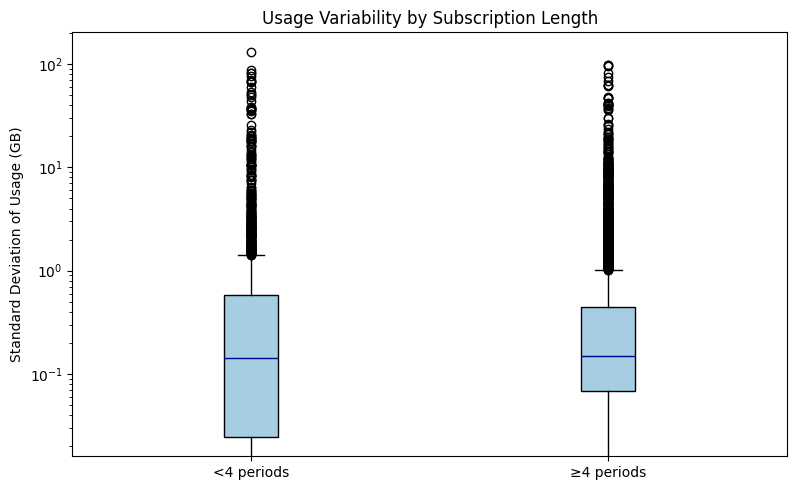

In [394]:
#Code for chart generated with AI 
import matplotlib.pyplot as plt

# Prepare grouped data
grouped = [
    variability_df[variability_df["group"] == "<4 periods"]["std_usage_gb"].dropna(),
    variability_df[variability_df["group"] == "≥4 periods"]["std_usage_gb"].dropna()
]

# Create the boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(grouped, labels=["<4 periods", "≥4 periods"], patch_artist=True,
            boxprops=dict(facecolor="#a6cee3", color="black"),
            medianprops=dict(color="darkblue"),
            whiskerprops=dict(color="black"))

plt.ylabel("Standard Deviation of Usage (GB)")
plt.title("Usage Variability by Subscription Length")
plt.tight_layout()
plt.yscale('log')
plt.show()


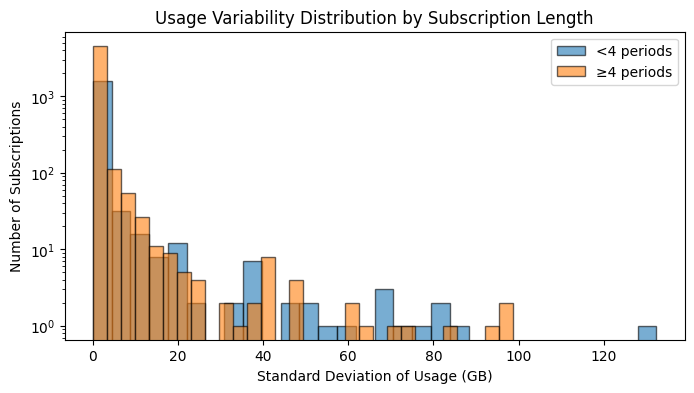

In [395]:
#Code for chart generated with AI 
plt.figure(figsize=(8, 4))

# Filter each group
short = variability_df[variability_df["group"] == "<4 periods"]["std_usage_gb"].dropna()
long = variability_df[variability_df["group"] == "≥4 periods"]["std_usage_gb"].dropna()

plt.hist(short, bins=30, alpha=0.6, label="<4 periods", edgecolor="black")
plt.hist(long, bins=30, alpha=0.6, label="≥4 periods", edgecolor="black")

plt.xlabel("Standard Deviation of Usage (GB)")
plt.ylabel("Number of Subscriptions")
plt.title("Usage Variability Distribution by Subscription Length")
plt.yscale("log")
plt.legend()
plt.show()


Findings: 
- Most subscriptions have relatively low variability, especially those with >= 4 periods
- The short lived subscriptions (43%) have high variability, indicating that use is not consistent and people might just be looking for a one-off use case.

Question 4: Compare the retention pattern for the most recently launched project versus the two older ones.

In [440]:
%%sql 
SELECT
  projects.project_type,
  organization_name,
  device_type,
  MIN(plan_created_at),
  MIN(_valid_from)
FROM
  projects
  LEFT JOIN plan_events ON plan_events.project_id__hashed = projects.project_id__hashed
  AND event_type = 'plan.published' -- taking plan published as the date when the plan went live 
GROUP BY
  projects.project_type,
  organization_name,
  device_type,

,project_type,organization_name,device_type,min(plan_created_at),min(_valid_from)
0,API,People Mobile,Phones,2025-03-03 18:42:39,2025-03-03 18:42:45.841068
1,Connect,ACME Phone,Phones,2023-12-29 18:42:14,2023-12-29 18:44:37.846803
2,Connect,SmartDevices Inc.,Wearables,2025-02-25 19:23:23,2025-02-25 19:28:35.658340


In [460]:
%%sql 
SELECT
  MIN(subscription_period_start),
  MAX(subscription_period_end),
  MAX(reporting_date)
FROM
  usage_data
  INNER JOIN projects ON projects.project_id__hashed = usage_data.project_id__hashed
  AND organization_name = 'People Mobile'
  AND subscription_period_number = 2

,min(subscription_period_start),max(subscription_period_end),max(reporting_date)
0,2025-05-01,2025-06-17,2025-06-16


Project is very new so limited number of users, will check the drop for users who could've been in month 2 but aren't

In [491]:
%%sql retention_data_df <<

WITH
  base_data AS (
    SELECT
      subscription_id,
      organization_name AS project_id,
      subscription_period_number
    FROM
      usage_data
      INNER JOIN projects ON projects.project_id__hashed = usage_data.project_id__hashed
  ),

  cohort_sizes AS (
    SELECT
      project_id,
      COUNT(DISTINCT subscription_id) AS starting_users
    FROM
      base_data
    WHERE
      subscription_period_number = 1
    GROUP BY
      project_id
  ),

  retention_counts AS (
    SELECT
      project_id,
      subscription_period_number,
      COUNT(DISTINCT subscription_id) AS active_users_in_period
    FROM
      base_data
    GROUP BY
      project_id, subscription_period_number
  ),

  retention_rates AS (
    SELECT
      r.project_id,
      r.subscription_period_number,
      r.active_users_in_period,
      c.starting_users,
      ROUND(r.active_users_in_period * 100.0 / c.starting_users, 1) AS retention_pct
    FROM
      retention_counts r
      JOIN cohort_sizes c ON r.project_id = c.project_id
  ),

  people_mobile_retention AS (
    WITH
      april_starters AS (
        SELECT
          subscription_id
        FROM
          usage_data
          INNER JOIN projects ON projects.project_id__hashed = usage_data.project_id__hashed
        WHERE
          organization_name = 'People Mobile'
          AND subscription_period_number = 1
          AND subscription_period_start >= '2025-04-01'
          AND subscription_period_start < '2025-05-01'
      ),

      with_period_2 AS (
        SELECT DISTINCT
          subscription_id
        FROM
          usage_data
          INNER JOIN projects ON projects.project_id__hashed = usage_data.project_id__hashed
        WHERE
          organization_name = 'People Mobile'
          AND subscription_period_number = 2
      )

    SELECT
      'People Mobile' AS project_id,
      1 AS subscription_period_number,
      COUNT(*) AS active_users_in_period,
      COUNT(*) AS starting_users,
      100.0 AS retention_pct
    FROM april_starters

    UNION ALL

    SELECT
      'People Mobile' AS project_id,
      2 AS subscription_period_number,
      COUNT(p2.subscription_id) AS active_users_in_period,
      COUNT(*) AS starting_users,
      ROUND(COUNT(p2.subscription_id) * 100.0 / COUNT(*), 1) AS retention_pct
    FROM april_starters a
    LEFT JOIN with_period_2 p2 ON a.subscription_id = p2.subscription_id
  )

SELECT * FROM retention_rates
WHERE project_id <> 'People Mobile'

UNION ALL

SELECT * FROM people_mobile_retention

ORDER BY project_id, subscription_period_number;


In [463]:
retention_data_df

,project_id,subscription_period_number,active_users_in_period,starting_users,retention_pct
0,ACME Phone,1,6708,6708,100.0
1,ACME Phone,2,5960,6708,88.8
2,ACME Phone,3,5264,6708,78.5
3,ACME Phone,4,4770,6708,71.1
4,ACME Phone,5,4309,6708,64.2
5,ACME Phone,6,3971,6708,59.2
6,ACME Phone,7,3682,6708,54.9
7,ACME Phone,8,3342,6708,49.8
8,ACME Phone,9,3063,6708,45.7
9,ACME Phone,10,2777,6708,41.4


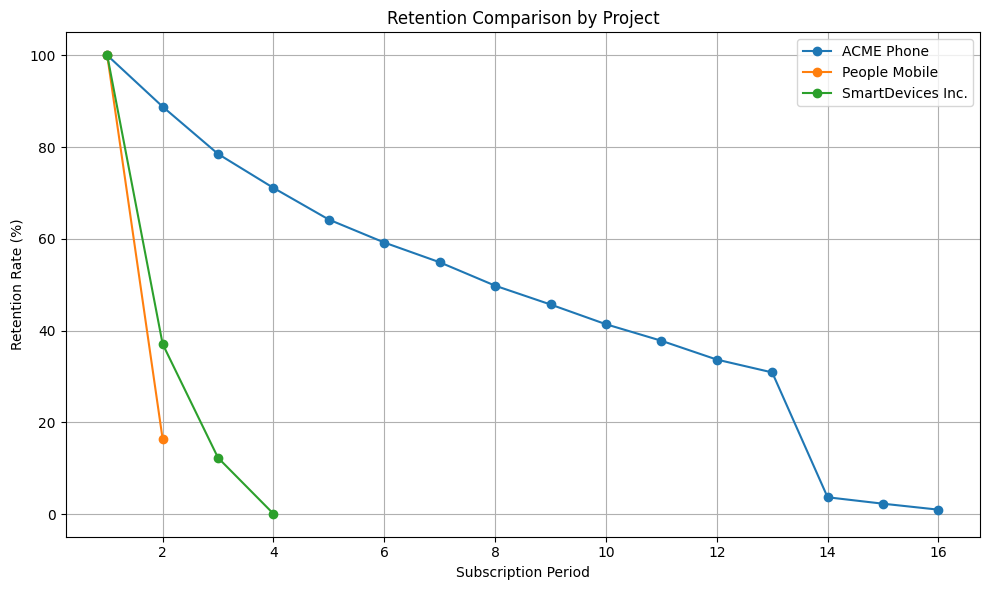

In [494]:
#Code for chart generated with AI 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for project_id in retention_data_df["project_id"].unique():
    subset = retention_data_df[retention_data_df["project_id"] == project_id]
    label = project_labels.get(project_id, project_id)
    
    plt.plot(
        subset["subscription_period_number"],
        subset["retention_pct"],
        marker="o",
        label=label
    )

plt.xlabel("Subscription Period")
plt.ylabel("Retention Rate (%)")
plt.title("Retention Comparison by Project")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Findings: 
- For the new Project for People Mobile retention drops from 100% to ~16% by period 2, with no data past period 2.
- KEEP IN MIND: project is brand new, so users simply haven’t reached later periods yet.

Might be too early to judge performance. Should connect with stakeholder to see if this is expected, if there were any onboarding challenges and if reasons on churn are available. 